# Solving an inverse problem

In [1]:
import numpy as np
import torch
import tensorboard, datetime
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
%matplotlib inline

## PDE

$\frac{\partial^2 u}{\partial x^2} = f(x) \text{ for } x \in (0,1)$

$u(0) = u(1) = 0$

$f(x)$ is unknown, but we are given training samples $\{x_i,u_i\}$

## Training data

In [2]:
def u_true(x):
    return (1/48)*(8*x*(x**2 - 1) - (3/np.pi**2)*np.sin(4*np.pi*x))

Text(0, 0.5, 'y')

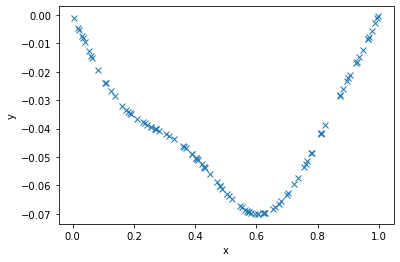

In [3]:
x_train = np.random.rand(100)
u_train = u_true(x_train)
plt.plot(x_train, u_train, 'x')
plt.xlabel('x')
plt.ylabel('y')

## Task

Use a PINN to find $u(x)$ and $f(x)$

In [21]:
xv = torch.linspace(0, 1, 100).float().unsqueeze(1)
x_train = torch.tensor(x_train).float().unsqueeze(1)

class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(1, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last_u = nn.Linear(nn_width, 1)
        self.layer_last_f = nn.Linear(nn_width, 1)
        
    def forward(self, x):
        #x = x.unsqueeze(1)
        activation = nn.Tanh()
        u = activation(self.layer_first(x))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        #print(u.shape)
        out_u = self.layer_last_u(u)
        out_f = self.layer_last_f(u)
        #print(out_u.shape, out_f.shape)
        return out_u, out_f

model = ffnn(15, 1)

def loss_function(model, x_t, xv):

  x = torch.tensor(x_t)
  _, out_f_t = model(x)


  x_grad = torch.tensor(xv, requires_grad=True)
  out_u_grad, out_f_grad = model(x_grad)
  
  dudx = torch.autograd.grad(out_u_grad, x_grad, grad_outputs=torch.ones_like(x_grad), create_graph=True, retain_graph=True)[0]

  dudxx = torch.autograd.grad(dudx, x_grad, grad_outputs=torch.ones_like(x_grad), create_graph=True, retain_graph=True)[0]

  f_loss = ((out_f_t - u_true(x)) ** 2).mean()
  phys_loss = ((dudxx - out_f_grad) ** 2).mean()

  phys_loss = phys_loss + f_loss*100
  return phys_loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Training

In [22]:
n_epochs = 20000
lr = 2.5e-3
loss_history = []
opt = torch.optim.Adam(model.parameters(), lr)


for i in range(n_epochs):

    loss = loss_function(model, x_train, xv)
    
    opt.zero_grad()
    
    
    loss.backward()
    opt.step()

    if i % 1000 == 0:
        print(f'epoch {i}, loss = {loss}')
        loss_history.append(loss.item())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0, loss = 0.8510638475418091
epoch 1000, loss = 0.0013667811872437596
epoch 2000, loss = 0.0012308746809139848
epoch 3000, loss = 0.0011754129081964493
epoch 4000, loss = 0.0011527854949235916
epoch 5000, loss = 0.0010983024258166552
epoch 6000, loss = 0.0010515706380829215
epoch 7000, loss = 0.0009887467604130507
epoch 8000, loss = 0.0008975075324997306
epoch 9000, loss = 0.0007353224791586399
epoch 10000, loss = 0.000347201363183558
epoch 11000, loss = 4.567447831504978e-05
epoch 12000, loss = 2.23006045416696e-05
epoch 13000, loss = 1.4959660802560393e-05
epoch 14000, loss = 1.0197331903327722e-05
epoch 15000, loss = 1.4371384168043733e-05
epoch 16000, loss = 1.0343483154429123e-05
epoch 17000, loss = 5.554400104301749e-06
epoch 18000, loss = 5.038121344114188e-06
epoch 19000, loss = 5.252166374702938e-06


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


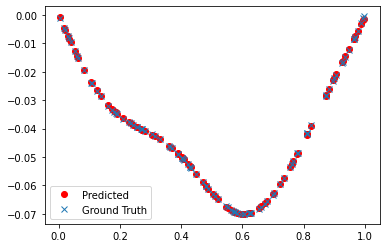

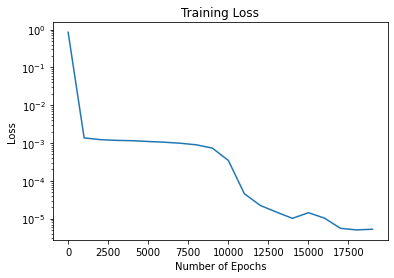

In [24]:
with torch.no_grad():
  x = torch.tensor(x_train)
  _, out_f_t = model(x)

plt.figure()
plt.plot(x_train.flatten(), out_f_t.flatten().numpy(),'ro', label = 'Predicted')
plt.plot(x_train.flatten(), u_train, 'x', label = 'Ground Truth')
plt.legend()
plt.show()

plt.figure()
plt.plot([1000*i for i in range(len(loss_history))], loss_history)
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.yscale('log')
plt.title('Training Loss')
plt.show()

